# Appendix

## main

Starting program

Generated 50 training data and 50 validation data from true model:
phi    : (-0.52)
sigma2 : 0.178

Model fit (logl -27.96) after 2 iterations (alim reached)

MAP estimate of true model parameters:
phi    : (-0.48)
sigma2 : 0.182

Crossvalidated logl: -20.80


/Users/cwestrup/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:17: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/cwestrup/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:30: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


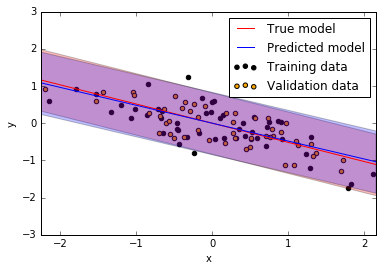

In [9]:
# Aalto University, School of Science
# T-61.5140 Machine Learning: Advanced probabilistic Methods
# Author: antti.kangasraasio@aalto.fi, 2016

import matplotlib.pyplot as plt
from numpy import arange, min, max, sqrt, mean, std
from scipy.spatial.distance import cosine
import numpy as np

def main():
    """
        Executed when program is run.
    """
    print("Starting program")
    print("")
    test_LM_model()


def test_LM_model():
    """
        Example that demonstrates how to call the model.
    """
    # get hyperparameters for model
    hyperp = get_hyperp()
    # generate 50 training data and 20 validation data locations of dim=1
    ndata = 50
    ndata_v = 50
    pdata = 1
    X = generate_X(ndata, pdata)
    X_v = generate_X(ndata_v, pdata)
    # intialize true model randomly and draw observations from it
    true_model = EM_algo_LM(hyperp, ndata=ndata, pdata=pdata)
    Y, Z = generate_YZ(X, true_model)
    Y_v, Z_v = generate_YZ(X_v, true_model)
    print("Generated %d training data and %d validation data from true model:" % \
            (ndata, ndata_v))
    true_model.print_p()
    print("")

    # generate a model for estimating the parameters of the
    # true model based on the observations (X, Y) we just made
    model = EM_algo_LM(hyperp, X, Y)
    i, logl, r = model.EM_fit()
    print("Model fit (logl %.2f) after %d iterations (%s reached)" % \
            (logl, i, r))
    print("")
    print("MAP estimate of true model parameters:")
    model.print_p()
    print("")

    # crossvalidate the estimated model with the validation data
    fit_params = model.get_p()
    model_v = EM_algo_LM(hyperp, X_v, Y_v)
    model_v.set_p(fit_params)
    logl, ll = model_v.logl()
    print("Crossvalidated logl: %.2f" % (logl))

    # if possible, plot samples, true model and estimated model
    if pdata != 1:
        return
    plt.scatter(X, Y, s=20, c='black', label="Training data")
    plt.scatter(X_v, Y_v, s=20, c='orange', label="Validation data")
    x = arange(min(X)-0.1, max(X)+0.1, 0.1)
    print_linear_model(x, true_model.get_p()["phi"], \
            true_model.get_p()["sigma2"], 'red', "True model")
    print_linear_model(x, model.get_p()["phi"], \
            model.get_p()["sigma2"], 'blue', "Predicted model")
    plt.legend(loc=1)
    plt.xlim(min(x), max(x))
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()


def print_linear_model(x, phi, sigma2, color, label):
    """
        Print linear model mean and 95% confidence interval.
    """
    y = phi * x
    plt.plot(x, y, color, label=label)
    plt.fill_between(x, y + 1.96 * sqrt(sigma2), y - 1.96 * sqrt(sigma2), \
            alpha=0.25, facecolor=color, interpolate=True)


if __name__ == "__main__":
    main()



In [5]:
%matplotlib inline

## EM Algorithm

In [6]:
# Aalto University, School of Science
# T-61.5140 Machine Learning: Advanced probabilistic Methods
# Author: antti.kangasraasio@aalto.fi, 2016

import copy

class EM_algo():
    """
        A superclass for different EM-fitted models.
    """

    def __init__(self, hyperparams, X=None, Y=None, ndata=0, pdata=0):
        """
            Initialize model based either on given data (X, Y) or
            on given data dimensionality (ndata, pdata).
        """
        if X != None and Y != None:
            self.X = X
            self.Y = Y
            self.ndata = len(self.X)
            self.pdata = len(self.X[0])
        if ndata and pdata:
            self.X = None
            self.Y = None
            self.ndata = ndata
            self.pdata = pdata
        self.h = hyperparams
        self.p = dict() # model parameters
        self.reset()
        if X != None and Y != None:
            self.current_logl, self.cll = self.logl()


    def reset(self):
        """
            Reset priors and draw parameter estimates from prior.
        """
        raise NotImplementedError("Subclass implements")


    def draw(self, item):
        """
            Draw a data sample from the current predictive distribution.
            Returns the drawn y and z-values.
        """
        raise NotImplementedError("Subclass implements")


    def logl(self):
        """
            Calculates the full log likelihood for this model.
            Returns the logl (and the values of each term for debugging purposes)
        """
        raise NotImplementedError("Subclass implements")


    def EM_iter(self):
        """
            Executes a single round of EM updates for this model.
        """
        raise NotImplementedError("Subclass implements")


    def EM_fit(self, alim=1e-10, maxit=1e4):
        """
            Calls the EM_iter repeatedly until the log likelihood
            of the model increases less than 'alim' in absolute
            value or after 'maxit' iterations have been done.

            Returns the number of EM-iterations, final log likelihood
            value and a string that explains the end condition.
        """
        logl, ll = self.logl()
        for i in range(int(maxit)):
            self.EM_iter()
            logl2, ll2 = self.logl()
            adiff = abs(logl2 - logl)
            if adiff < alim:
                return i+1, logl2, "alim"
            logl = logl2
        return maxit, logl2, "maxit"


    def assert_logl_increased(self, event):
        """
            Checks that the log likelihood increased since model
            initialization or the time this function was last called.
        """
        newlogl, ll = self.logl()
        if self.current_logl - newlogl > 1e-3:
            self.debug_logl(self.cll, ll)
            raise ValueError("logl increased after %s" % (event))
        self.current_logl, self.cll = newlogl, ll


    def get_p(self):
        """
            Returns a copy of the model parameters.
        """
        return copy.deepcopy(self.p)


    def set_p(self, p):
        """
            Sets the model parameters.
        """
        self.p = p.copy()


    def print_p(self):
        """
            Prints the model parameters, one at each line.
        """
        for k, v in self.p.items():
            print("%s = %s" % (k, v))


    def pretty_vector(self, x):
        """
            Returns a formatted version of a vector.
        """
        s = ["("]
        s.extend(["%.2f, " % (xi) for xi in x[:-1]])
        s.append("%.2f)" % (x[-1]))
        return "".join(s)


    def debug_logl(self, ll1, ll2):
        """
            Prints an analysis of the per-term change in
            log likelihood from ll1 to ll2.
        """
        print("Logl      before     after")
        for v1, v2, i in zip(ll1, ll2, range(len(ll1))):
            if v1 > v2:
                d = ">"
            elif v2 > v1:
                d = "<"
            else:
                d = "="
            print("Term %02d: %7.3f %s %7.3f" % (i, v1, d, v2))
        print("Total    %7.3f   %7.3f" % (sum(ll1), sum(ll2)))



## Generator

In [7]:
# Aalto University, School of Science
# T-61.5140 Machine Learning: Advanced probabilistic Methods
# Author: antti.kangasraasio@aalto.fi, 2016

from numpy import zeros
from numpy.random import randn


def generate_X(ndata, pdata):
    """
        Return a matrix of normally distributed random values.
    """
    X = randn(ndata, pdata)
    return X


def generate_YZ(X, distribution):
    """
        Draw observations Y and latent variable values Z from a distribution.
    """
    ndata = len(X)
    Y = zeros(ndata)
    Z = zeros(ndata)
    for i in range(ndata):
        Y[i], Z[i] = distribution.draw(X[i])
    return Y, Z


def get_hyperp():
    """
        Return model hyperparameters.
    """
    return {
            "alpha_s20": 5.0,
            "beta_s20" : 1.0,
            "lbd_phi0" : 1.0,
            "mu_phi0"  : 0.0,
            "alpha_w0" : 3.0,
            "beta_w0"  : 3.0,
            }


## Linear model

In [8]:
# Aalto University, School of Science
# T-61.5140 Machine Learning: Advanced probabilistic Methods
# Author: antti.kangasraasio@aalto.fi, 2016

from numpy import outer, eye, ones, zeros, log, sqrt, exp, pi
from numpy.linalg import inv, solve
from numpy.random import multivariate_normal as mvnormal, normal, gamma, beta, binomial
from scipy.special import gammaln

class EM_algo_LM(EM_algo):
    """
        A linear gaussian model.
    """

    def reset(self):
        """
            Reset priors and draw parameter estimates from prior.
        """
        # priors
        self.lbd_phi0       = self.h["lbd_phi0"]
        self.alpha_s20      = self.h["alpha_s20"]
        self.beta_s20       = self.h["beta_s20"]
        self.sigma_phi0     = eye(self.pdata) * self.h["lbd_phi0"]
        self.sigma_phi0_inv = eye(self.pdata) / self.h["lbd_phi0"]
        self.mu_phi0        = ones(self.pdata) * self.h["mu_phi0"]

        # initial parameter estimates drawn from prior
        self.p           = dict()
        self.p["sigma2"] = 1.0 / gamma(self.alpha_s20, 1.0 / self.beta_s20) # inverse gamma
        self.p["phi"]    = mvnormal(self.mu_phi0, self.p["sigma2"] * self.sigma_phi0)


    def draw(self, item):
        """
            Draw a data sample from the current predictive distribution.
            Returns the y-value (and a constant z-value for compatibility)
        """
        mean = float(item.dot(self.p["phi"]))
        std  = sqrt(self.p["sigma2"])
        return normal(mean, std), 1


    def logl(self):
        """
            Calculates the full log likelihood for this model.
            Returns the logl (and the values of each term for debugging purposes)
        """
        ll    = zeros(8)
        phie  = self.p["phi"] - self.mu_phi0
        err   = (self.X.dot(self.p["phi"]) - self.Y) ** 2
        # p(y)
        ll[0] = - 0.5 * log(2 * pi * self.p["sigma2"]) * self.ndata
        ll[1] = sum(- 0.5 * err / self.p["sigma2"])
        # p(phi)
        ll[2] = - 0.5 * log(2 * pi * self.lbd_phi0 * self.p["sigma2"]) * self.pdata
        ll[3] = - 0.5 * phie.T.dot(phie) / (self.lbd_phi0 * self.p["sigma2"])
        # p(sigma2)
        ll[4] = self.alpha_s20 * log(self.beta_s20)
        ll[5] = - gammaln(self.alpha_s20)
        ll[6] = - (self.alpha_s20 + 1.0) * log(self.p["sigma2"])
        ll[7] = - self.beta_s20 / self.p["sigma2"]
        return sum(ll), ll


    def EM_iter(self):
        """
            Executes a single round of EM updates for this model.

            Has checks to make sure that updates increase logl and
            that parameter values stay in sensible limits.
        """
        # phi
        sumxx         = self.X.T.dot(self.X)
        sumxy         = self.X.T.dot(self.Y)
        sigma_mu      = self.sigma_phi0_inv.dot(self.mu_phi0)
        sigma_phi_inv = self.sigma_phi0_inv + sumxx
        self.p["phi"] = solve(sigma_phi_inv, sigma_mu + sumxy)
        self.assert_logl_increased("phi update")

        # sigma2
        phie = (self.p["phi"] - self.mu_phi0) ** 2
        err  = (self.X.dot(self.p["phi"]) - self.Y) ** 2
        num  = self.beta_s20 + 0.5 * sum(err) + 0.5 * sum(phie) / self.lbd_phi0
        den  = self.alpha_s20 + 1.0 + 0.5 * (self.ndata + self.pdata)
        self.p["sigma2"] = num / den
        if self.p["sigma2"] < 0.0:
            raise ValueError("sigma2 < 0.0")
        self.assert_logl_increased("sigma2 update")


    def print_p(self):
        """
            Prints the model parameters, one at each line.
        """
        print("phi    : %s" % (self.pretty_vector(self.p["phi"])))
        print("sigma2 : %.3f" % (self.p["sigma2"]))



## Mixture Model

In [ ]:
# Aalto University, School of Science
# T-61.5140 Machine Learning: Advanced probabilistic Methods
# Author: antti.kangasraasio@aalto.fi, 2016

from numpy import outer, eye, ones, zeros, diag, log, sqrt, exp, pi
from numpy.linalg import inv, solve
from numpy.random import multivariate_normal as mvnormal, normal, gamma, beta, binomial
from scipy.special import gammaln

class EM_algo_MM(EM_algo):
    """
        A mixture of two linear models.
    """

    def reset(self):
        pass


    def draw(self, item):
        return None, None


    def logl(self):
        return None, None


    def EM_iter(self):
        pass

